# Continuum Source Detection

In [1]:
# This is done for keeping the notebook clean, remove this if you are using this notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://data.csiro.au/collections/domain/casdaSkymap/summary/catalogue/RACS_0730-68A_component_53b/continuum_component
# https://data.csiro.au/domain/casdaObservation/results?dataProducts=%5B%7B%22dataProduct%22%3A%22CATALOGUE%22%7D,%7B%22dataProduct%22%3A%22IMAGE_CUBE%22%7D,%7B%22dataProduct%22%3A%22IMAGE_CUBE_ANCILLARY%22%7D,%7B%22dataProduct%22%3A%22SPECTRUM%22%7D,%7B%22dataProduct%22%3A%22MEASUREMENT_SET%22%7D%5D&facets=%5B%5D&showRejected=false&releasedFilter=released&includeCommensalProjects=false&showFacets=true&coneSearches=%5B%7B%22rightAscension%22%3A%2208%3A16%3A36.828%22,%22declination%22%3A%22-70%3A39%3A55.573%22,%22radius%22%3A2%7D%5D&objectName=J081636-703955

# 2MASX J08161181-7039447

SB12486_fits = "AS110/RACS0830-68A/image.i.SB12486.cont.RACS_0830-68A.linmos.taylor.0.restored.fcor.fits"

section_fits = "SB12486_section.fits"

In [3]:
# Helper to plot data

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import os

%matplotlib inline

def plot_fits(hdu, gamma=0.3, vmin=0, vmax=None):
    wcs = WCS(hdu.header, naxis=2)
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection=wcs)

    if vmax is not None:
        im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)        
    else:
        im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', norm=mcolors.PowerNorm(gamma))
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.set_autoscale_on(False)
    ax.set_title("image")
    plt.colorbar(im, ax=ax)

    plt.tight_layout(pad=3, w_pad=2, h_pad=2)
    plt.show()

In [4]:
file = SB12486_fits

SB12486_hdu = fits.open(file)[0]
SB12486_data = SB12486_hdu.data

SB12486_data.shape

(1, 1, 14533, 14537)

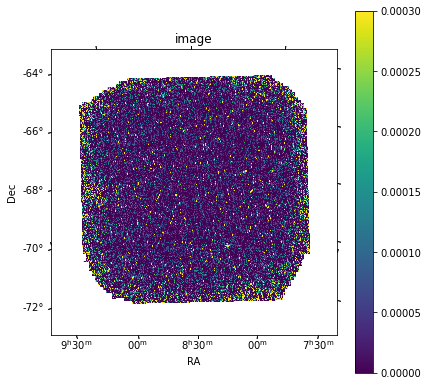

In [5]:
plot_fits(SB12486_hdu, vmin=0, vmax=300e-6)

## Extracting a section of the Sky

In [6]:
def split(hdu, xst, xen, yst, yen):
    ref = SkyCoord(hdu.header["CRVAL1"], hdu.header["CRVAL2"], unit='deg')
    ref_px_x, ref_px_y = hdu.header["CRPIX1"], hdu.header["CRPIX2"]

    delta_1 = hdu.header["CDELT1"] * u.deg
    delta_2 = hdu.header["CDELT2"] * u.deg

    w = WCS(hdu.header, naxis=2)

    xsize = xen - xst
    ysize = yen - yst

    coord = w.pixel_to_world(xst, yst)
    print(ref.ra.hms, ref.dec.hms)
    print(coord.ra.hms, coord.dec.hms)

    new_data = hdu.data[:,:,xst:xen,yst:yen]
    new_wcs = WCS(naxis=4)

    new_wcs.wcs.crpix = [0, 0, 1, 1]
    new_wcs.wcs.cunit = ['deg', 'deg', 'Hz', '']
    new_wcs.wcs.cdelt = np.array([delta_1.value, delta_2.value, 1, 1])
    new_wcs.wcs.crval = [coord.ra.deg, coord.dec.deg, 1, 1]
    new_wcs.wcs.ctype = ['RA---SIN', 'DEC--SIN', 'FREQ', 'STOKES']

    new_hdu = fits.PrimaryHDU(data=new_data, header=new_wcs.to_header())

    return new_hdu


hms_tuple(h=8.0, m=24.0, s=21.576000000005138) hms_tuple(h=-4.0, m=-32.0, s=-33.717333333604955)
hms_tuple(h=8.0, m=38.0, s=32.485454225659964) hms_tuple(h=-4.0, m=-37.0, s=-24.959874028452163)


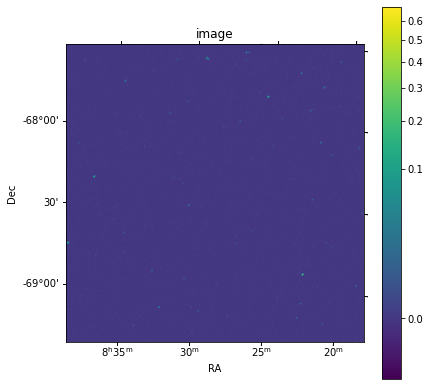

In [7]:
fits_file = "image.i.section.fits"

os.system(f"rm {fits_file}")

hdu = SB12486_hdu
ref = SkyCoord(hdu.header["CRVAL1"], hdu.header["CRVAL2"], unit='deg')
ref_x, ref_y = int(hdu.header["CRPIX1"]), int(hdu.header["CRPIX2"])
delta_1 = hdu.header["CDELT1"] * u.deg
delta_2 = hdu.header["CDELT2"] * u.deg
w = WCS(hdu.header, naxis=2)

hdu_split = split(SB12486_hdu, 6223, 8847, 6334, 8958)
hdu_split.writeto(fits_file)
plot_fits(hdu_split, 0.3)

## Source Detection

In [ ]:
from taitale import taitale_env

env = taitale_env(
    image = "csirocass/askapsoft",
    tag = "1.17.6-openmpi4"
)


In [8]:
from taitale.askap import selavy

# Distributed 2x2 grid source detection
selavy(
    env=env,
    workers=5,
    args={
        "image": fits_file,
        "weights": False,
        "resultsFile": "selavy-catalog.txt",
        "VariableThreshold": False,
        "Fitter.doFit": True,
        "nsubx": 2,
        "nsuby": 2,
    }
)

Starting selavy
selavy complete


## Verify the VO tables

In [9]:
from astropy.io.votable import parse

def read_votable(name):
    votable = parse(name)

    for resource in votable.resources:
        for table in resource.tables:
            print(table)

read_votable("selavy-catalog.islands.xml")

col_island_id col_island_name col_n_components ... col_flag_i4 col_comment
      --                                       ...                        
------------- --------------- ---------------- ... ----------- -----------
     island_1      B0822-6853                2 ...           0            
    island_10      B0834-6745                1 ...           0            
   island_100      B0831-6904                1 ...           0            
   island_101      B0829-6806                1 ...           0            
   island_102      B0824-6730                0 ...           0            
   island_103      B0837-6848                0 ...           0            
   island_104      B0828-6859                1 ...           0            
   island_105      B0829-6845                1 ...           0            
   island_106      B0830-6818                0 ...           0            
   island_107      B0822-6855                1 ...           0            
          ...            

In [10]:
read_votable("selavy-catalog.components.xml")

col_island_id col_component_id col_component_name ... col_flag_c4 col_comment
      --             --                           ...                        
------------- ---------------- ------------------ ... ----------- -----------
     island_1     component_1a         B0822-6853 ...           0            
     island_1     component_1b         B0822-6853 ...           0            
     island_2     component_2a         B0836-6820 ...           0            
     island_3     component_3a         B0825-6749 ...           1            
     island_4     component_4a         B0838-6844 ...           1            
     island_5     component_5a         B0829-6736 ...           1            
     island_5     component_5b         B0829-6736 ...           1            
     island_6     component_6a         B0826-6733 ...           0            
     island_6     component_6b         B0826-6733 ...           0            
     island_8     component_8a         B0832-6908 ...           